Libraries imported.
Seaborn theme set.
Loaded 40 initial responses from Survey.csv.
Columns successfully renamed.
Data cleaned and prepped. Final dataset has N=40 responses.
Saved plot_field_of_study_pie.png
Saved plot_academic_level_bar.png
Saved plot_frequency_bar.png
Saved plot_freq_by_field_grouped_bar.png
Saved plot_popular_tools_bar.png
Saved plot_popular_tasks_bar.png
Saved plot_reliance_bar.png
Saved plot_reliance_vs_factcheck_stacked.png
Saved plot_performance_bar.png

--- All 9 plots have been generated and saved as PNG files. ---


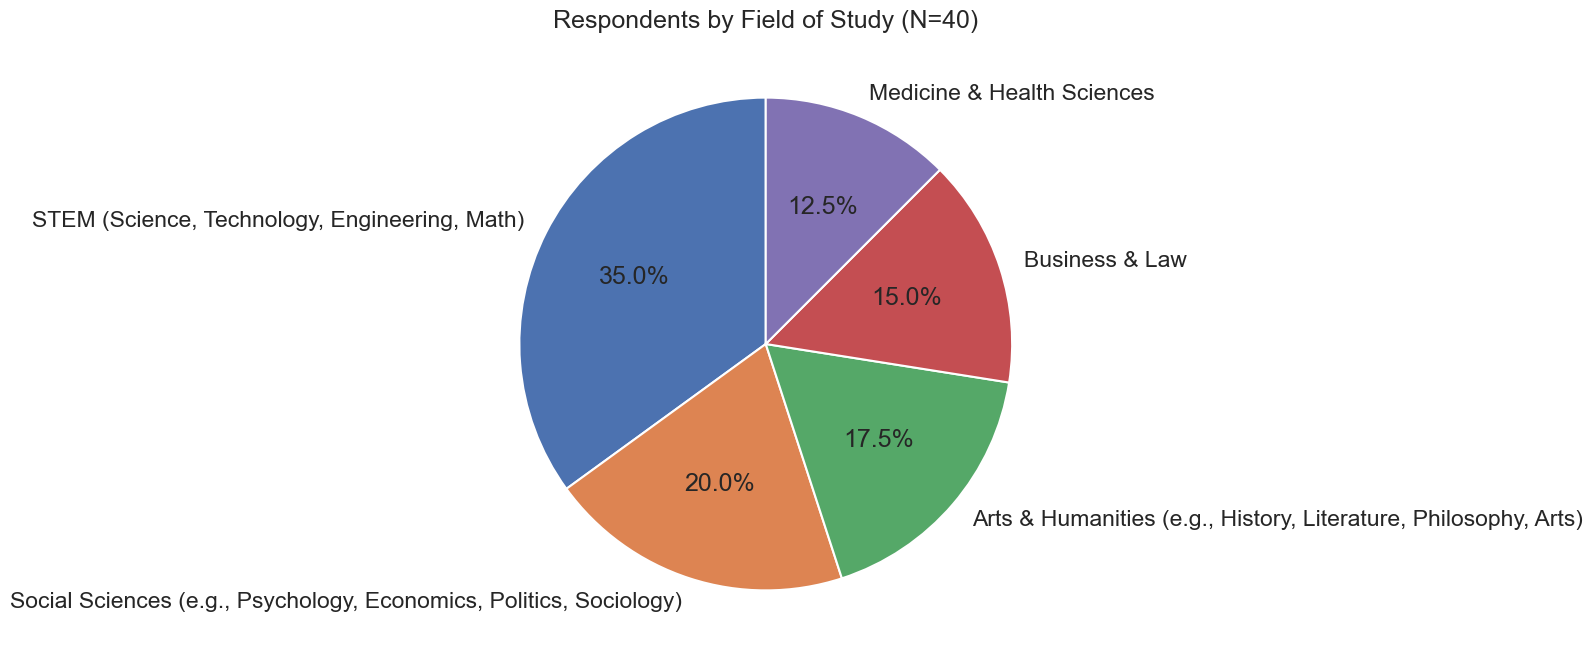

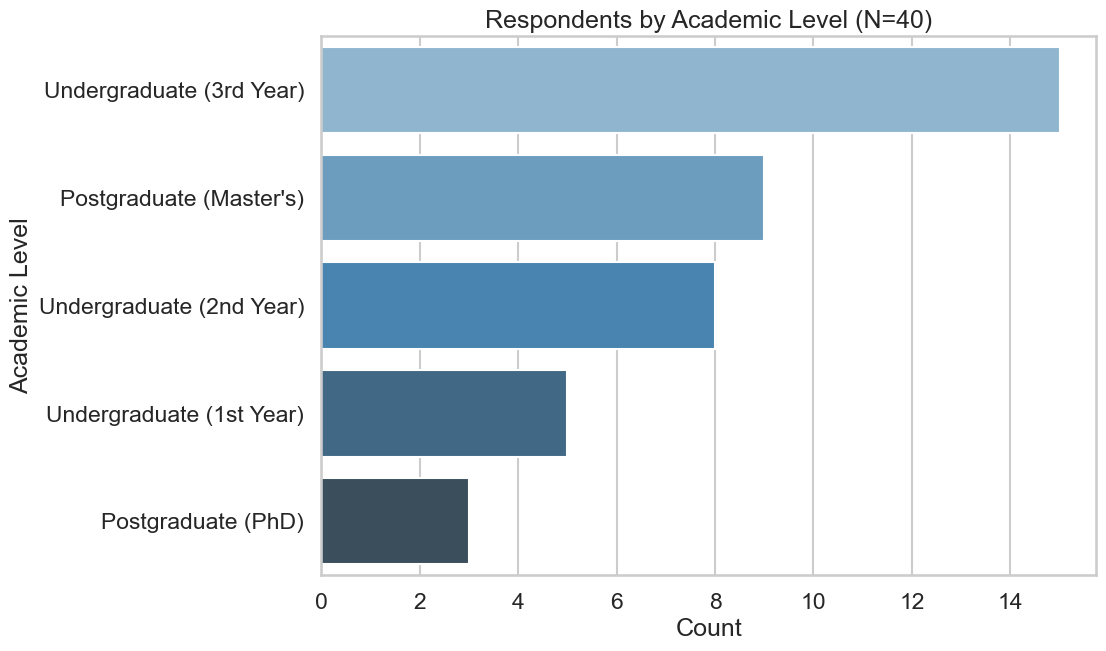

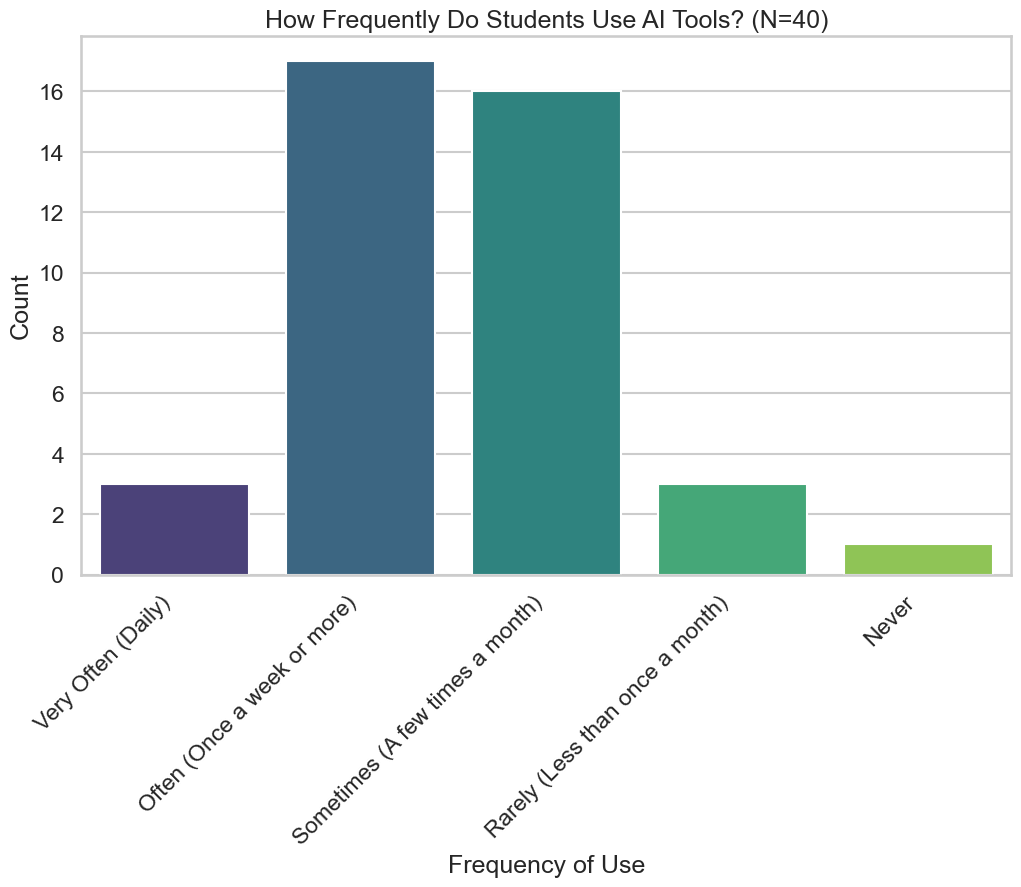

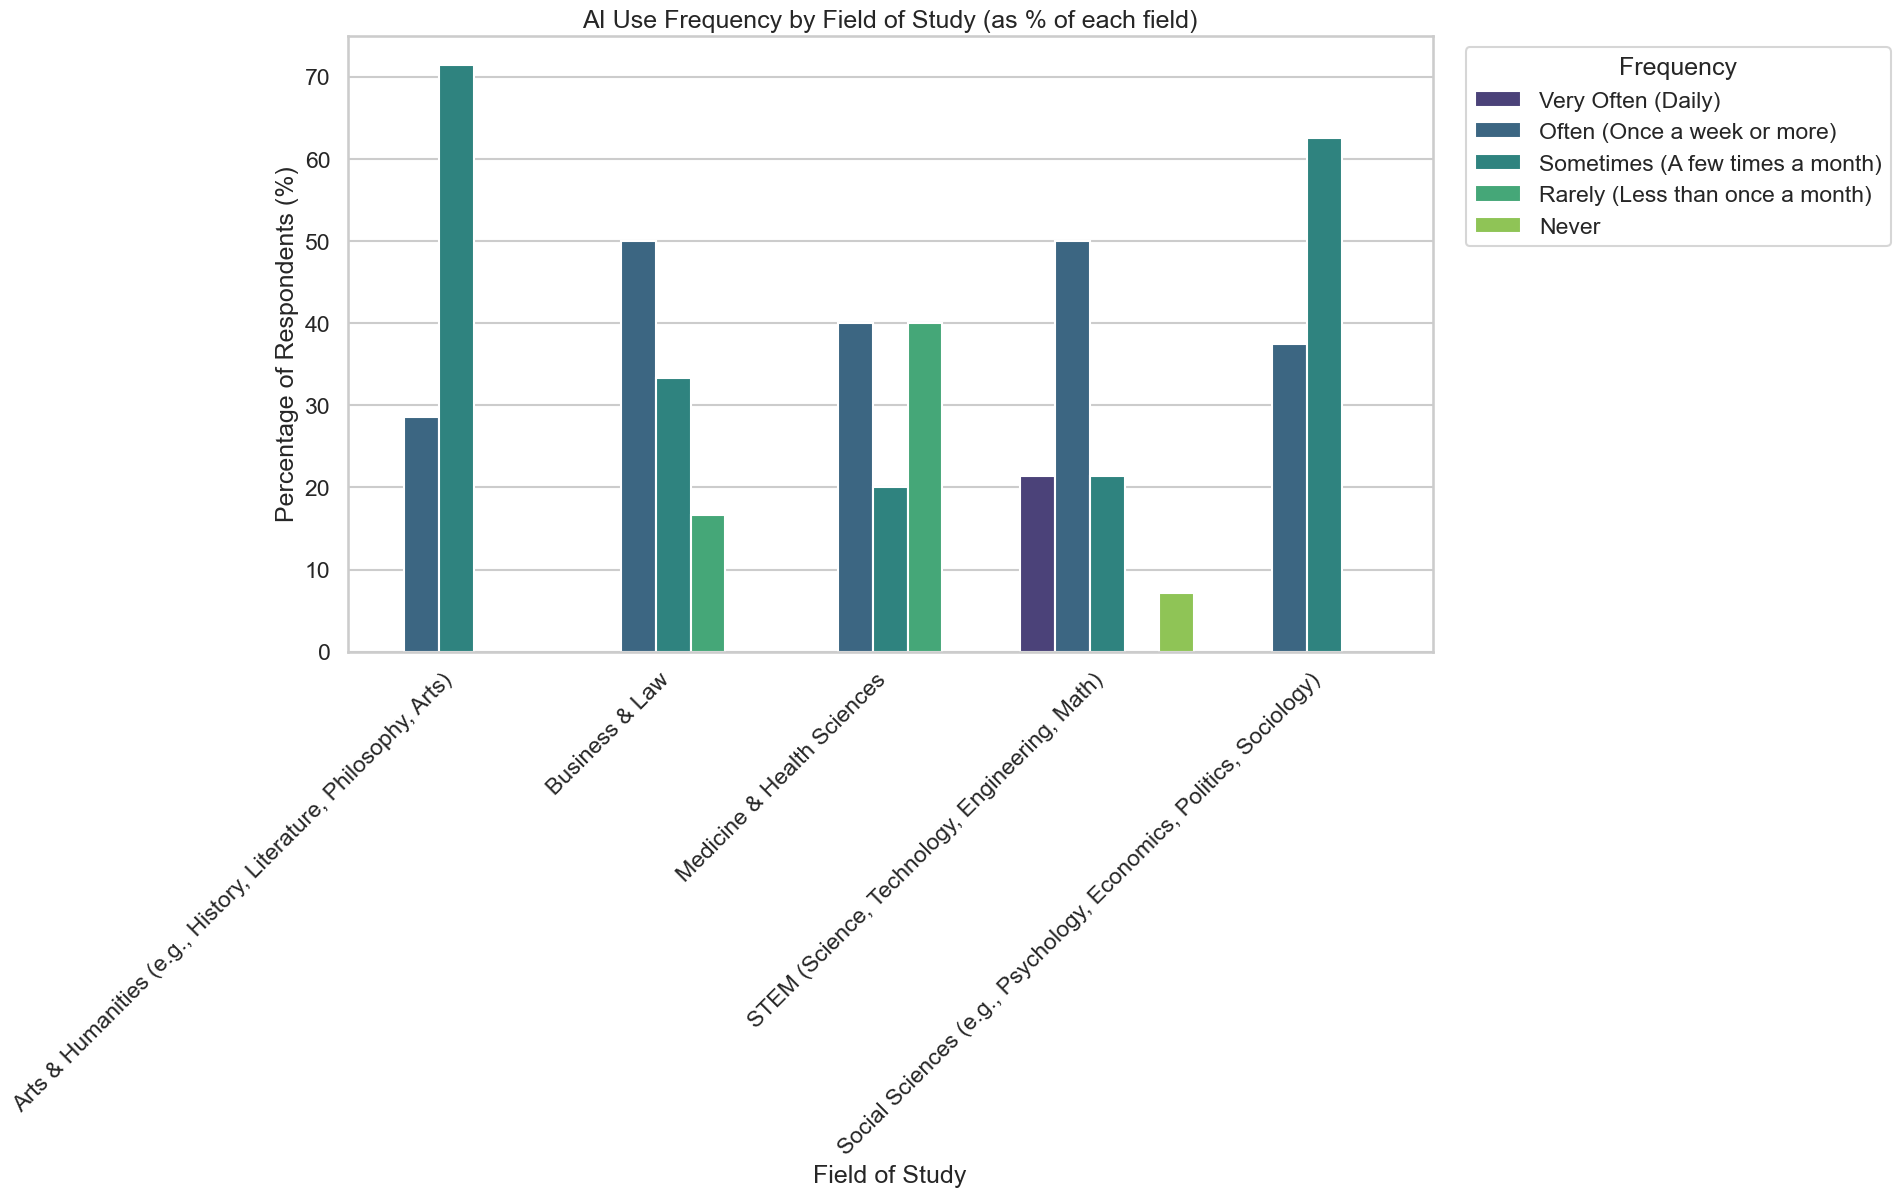

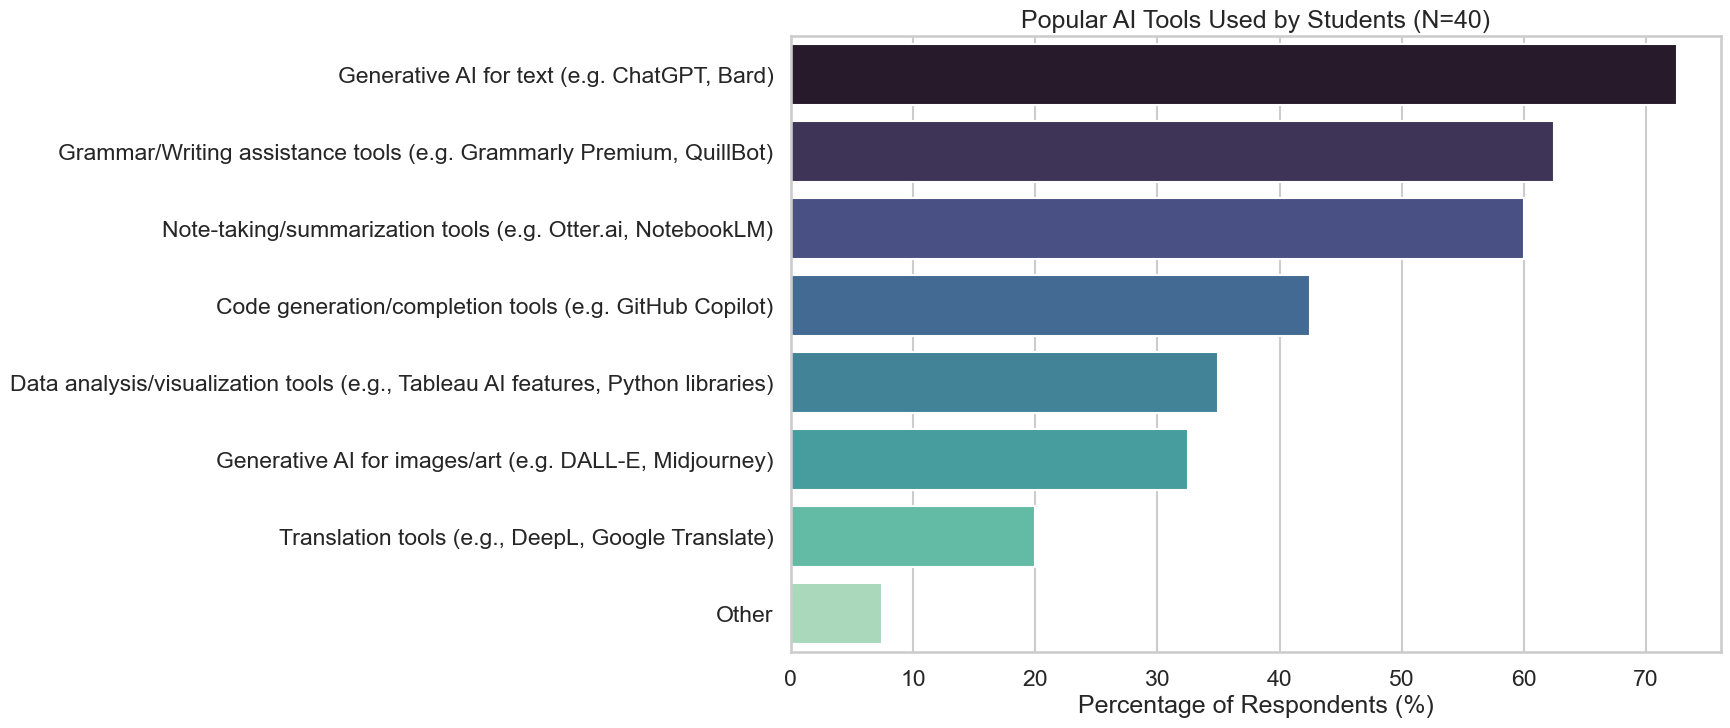

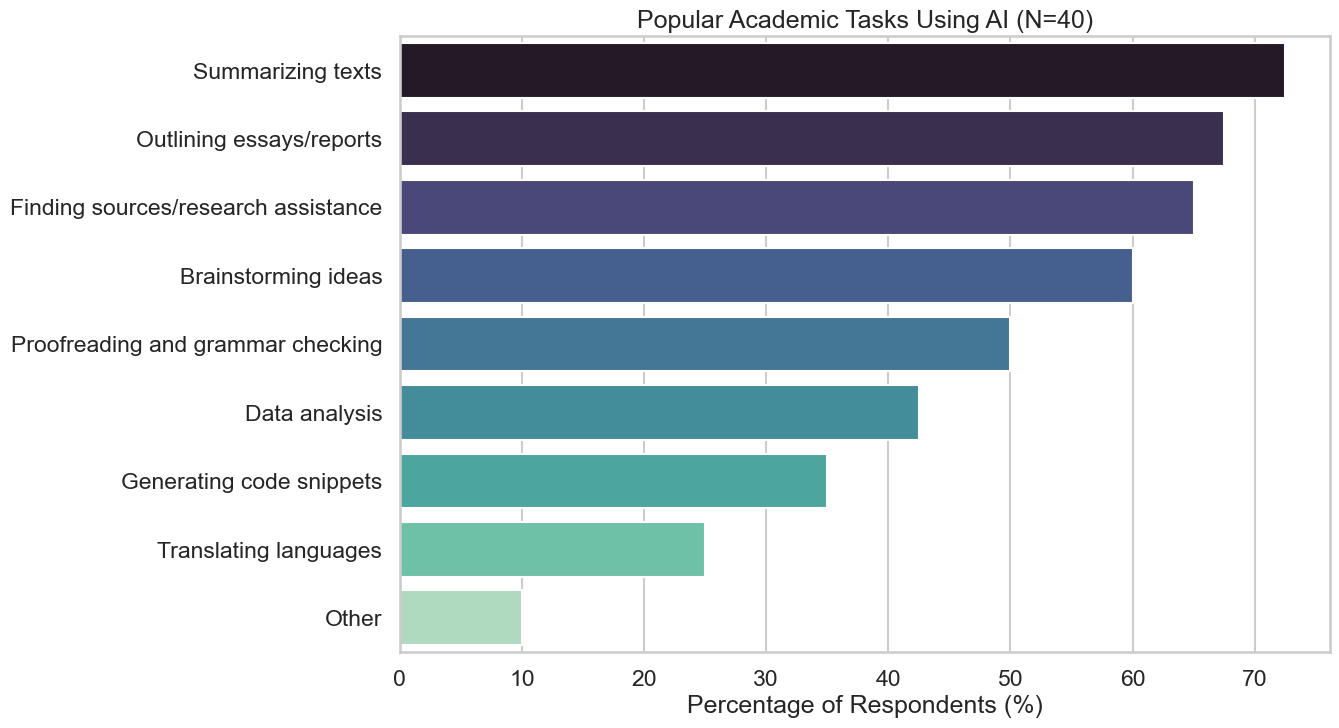

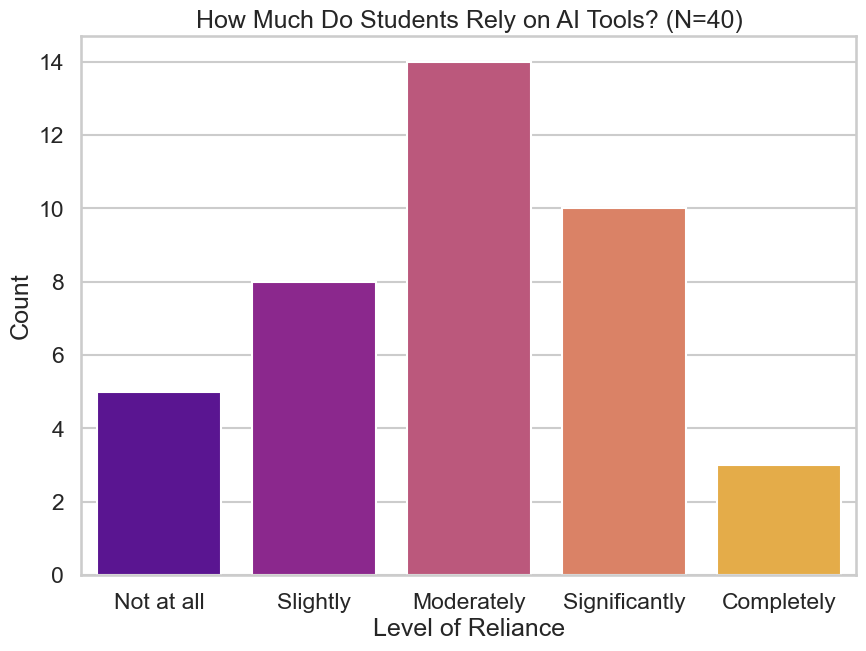

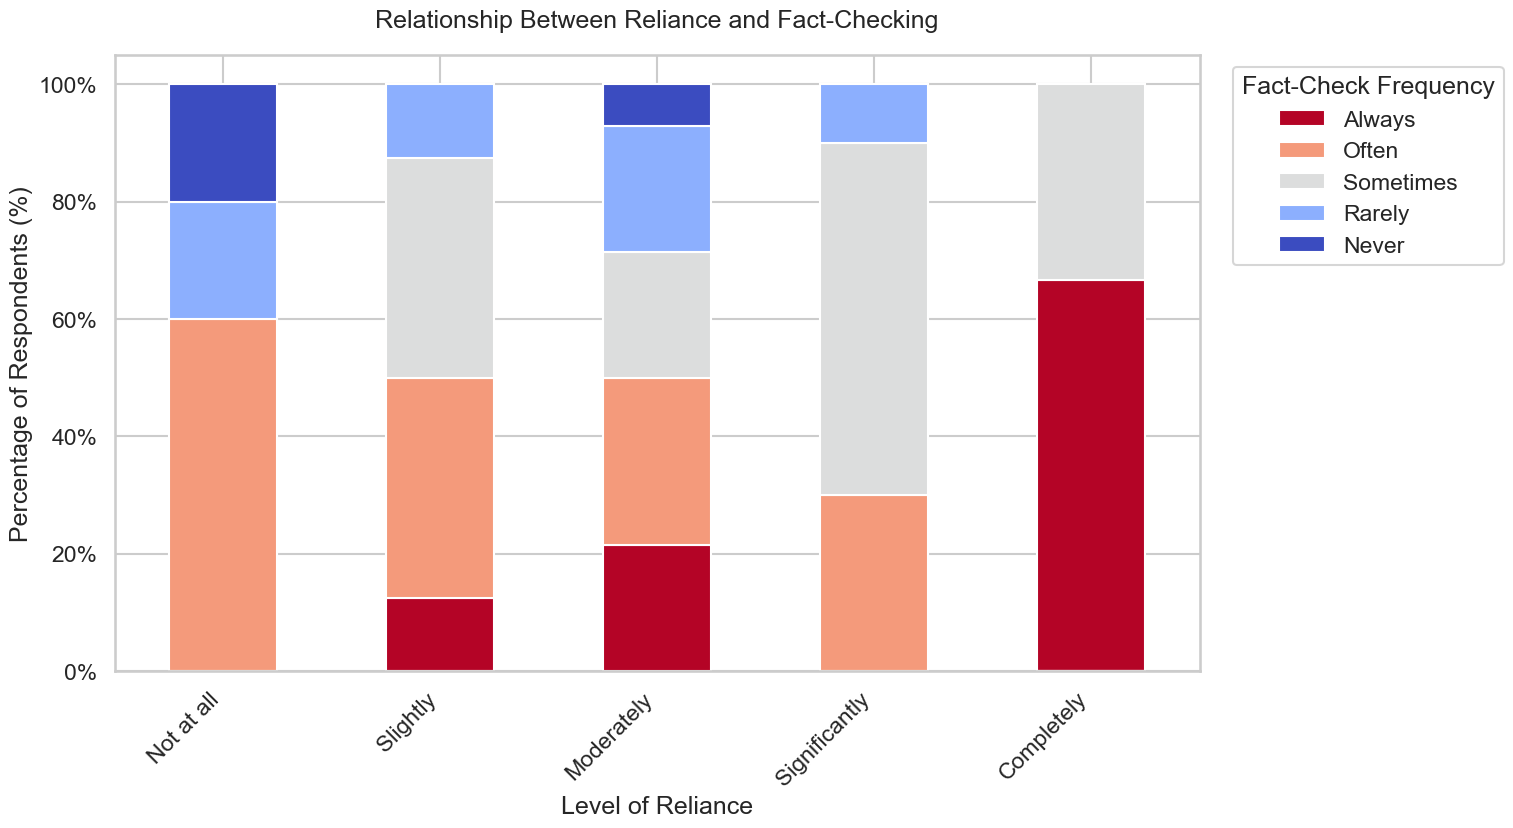

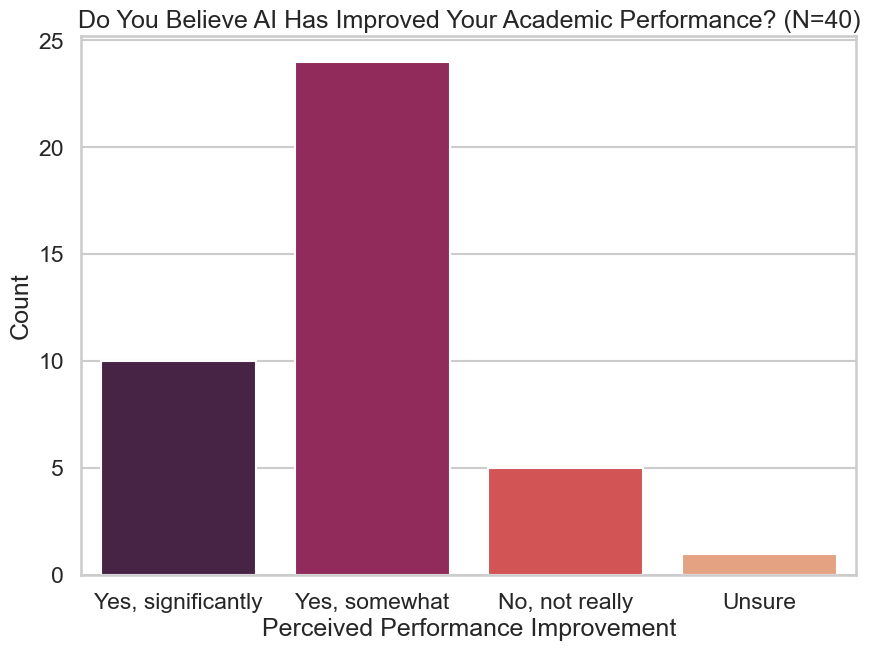

In [15]:
# 1. SETUP & DATA LOADING
# --------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported.")

# Set the visual theme for all plots
sns.set_theme(style="whitegrid", context="talk")
print("Seaborn theme set.")

# Load the dataset
try:
    data_full = pd.read_csv('Survey.csv')
    print(f"Loaded {data_full.shape[0]} initial responses from Survey.csv.")
except FileNotFoundError:
    print("ERROR: 'Survey.csv' not found. Make sure it's in the same directory.")
    # Create a dummy dataframe to prevent further errors if file not found
    data_full = pd.DataFrame()

if not data_full.empty:
    # 2. DATA CLEANING & PREP
    # --------------------------------
    
    # --- THIS IS THE CORRECTED MAP ---
    # Based on the exact column list you provided.
    col_map = {
        'What is your current academic level?': 'Academic Level',
        'What is your primary field of study?': 'Field of Study',
        'How frequently do you use AI tools for academic purposes?': 'Frequency',
        'Which of the following AI tools have you used for academic tasks in the past 30 days? (Select all that apply)': 'Tools Used',
        'For which of the following academic tasks do you use AI tools? (Select all that apply)': 'Tasks Used For',
        'How much do you rely on AI tools to generate initial drafts or ideas for your academic assignments? ': 'Reliance', # FIX: Trailing space included
        'How frequently do you cross-reference information provided by AI tools with other sources?': 'Fact-Check Frequency',
        'Do you believe the use of AI tools has improved your academic performance? ': 'Performance Improvement' # FIX: Trailing space included
    }
    
    # Rename columns for easy access
    data_renamed = data_full.rename(columns=col_map)
    print("Columns successfully renamed.")
    
    # [cite_start]Clean messy 'Academic Level' data as specified [cite: 204-205]
    replacements = {
        '3st Year Undergraduate': 'Undergraduate (3rd Year)',
        '2st Year Undergraduate': 'Undergraduate (2nd Year)',
        '1st Year Undergraduate': 'Undergraduate (1st Year)'
    }
    data_renamed['Academic Level'] = data_renamed['Academic Level'].replace(replacements)
    
    # Handle missing data (This line should now work)
    key_cols = ['Academic Level', 'Field of Study', 'Frequency', 'Reliance', 'Fact-Check Frequency']
    data_cleaned = data_renamed.dropna(subset=key_cols)
    
    # SLICE THE DATA: Take the first 40 rows as the final dataset
    data = data_cleaned.head(40).copy()
    
    # Set total N for percentages
    total_responses = data.shape[0]
    print(f"Data cleaned and prepped. Final dataset has N={total_responses} responses.")

    # 3. PLOT GENERATION
    # --------------------------------
    
    # Define logical order for categorical variables
    frequency_order = ['Very Often (Daily)', 'Often (Once a week or more)', 'Sometimes (A few times a month)', 'Rarely (Less than once a month)', 'Never']
    reliance_order = ['Not at all', 'Slightly', 'Moderately', 'Significantly', 'Completely']
    factcheck_order = ['Always', 'Often', 'Sometimes', 'Rarely', 'Never']
    performance_order = ['Yes, significantly', 'Yes, somewhat', 'No, not really', 'Unsure']

    # --- Plot 1: plot_field_of_study_pie.png (Demographics) --- 
    plt.figure(figsize=(10, 8))
    field_counts = data['Field of Study'].value_counts()
    plt.pie(field_counts, labels=field_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Respondents by Field of Study (N={total_responses})')
    plt.savefig('plot_field_of_study_pie.png', dpi=300, bbox_inches='tight')
    print("Saved plot_field_of_study_pie.png")

    # --- Plot 2: plot_academic_level_bar.png (Demographics) --- 
    plt.figure(figsize=(10, 7))
    sns.countplot(data=data, y='Academic Level', order=data['Academic Level'].value_counts().index, palette='Blues_d')
    plt.title(f'Respondents by Academic Level (N={total_responses})')
    plt.xlabel('Count')
    plt.ylabel('Academic Level')
    plt.savefig('plot_academic_level_bar.png', dpi=300, bbox_inches='tight')
    print("Saved plot_academic_level_bar.png")

    # --- Plot 3: plot_frequency_bar.png (RQ1) --- 
    plt.figure(figsize=(12, 7))
    sns.countplot(data=data, x='Frequency', order=frequency_order, palette='viridis')
    plt.title(f'How Frequently Do Students Use AI Tools? (N={total_responses})')
    plt.xlabel('Frequency of Use')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.savefig('plot_frequency_bar.png', dpi=300, bbox_inches='tight')
    print("Saved plot_frequency_bar.png")

    # --- Plot 4: plot_freq_by_field_grouped_bar.png (RQ1) --- 
    # [cite_start]This is the complex grouped bar chart [cite: 227-232]
    grouped_data = data.groupby('Field of Study')['Frequency'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
    
    # Re-order the 'Frequency' to match the specified order for plotting
    grouped_data['Frequency'] = pd.Categorical(grouped_data['Frequency'], categories=frequency_order, ordered=True)
    
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=grouped_data,
        x='Field of Study',
        y='Percentage',
        hue='Frequency',
        palette='viridis',
        hue_order=frequency_order
    )
    plt.title('AI Use Frequency by Field of Study (as % of each field)')
    plt.xlabel('Field of Study')
    plt.ylabel('Percentage of Respondents (%)')
    plt.legend(title='Frequency', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.savefig('plot_freq_by_field_grouped_bar.png', dpi=300, bbox_inches='tight')
    print("Saved plot_freq_by_field_grouped_bar.png")

    # [cite_start]--- Plot 5 & 6: Helper Function and Plots for Tools & Tasks --- [cite: 234-235]
    def plot_multiselect(column_name, title, filename):
        # Count all occurrences, splitting by ';'
        all_items = Counter()
        data[column_name].dropna().apply(lambda x: all_items.update([item.strip() for item in x.split(';')]))
        
        # Convert counter to DataFrame for plotting
        item_df = pd.DataFrame(all_items.items(), columns=['Item', 'Count']).sort_values(by='Count', ascending=False)
        
        # Calculate Percentage
        item_df['Percentage'] = (item_df['Count'] / total_responses) * 100
        
        # Plot horizontal bar chart
        plt.figure(figsize=(12, 8))
        sns.barplot(data=item_df, x='Percentage', y='Item', palette='mako')
        plt.title(f'{title} (N={total_responses})')
        plt.xlabel('Percentage of Respondents (%)')
        plt.ylabel('')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename}")

    # Plot 5: Popular Tools
    plot_multiselect('Tools Used', 'Popular AI Tools Used by Students', 'plot_popular_tools_bar.png')
    
    # Plot 6: Popular Tasks
    plot_multiselect('Tasks Used For', 'Popular Academic Tasks Using AI', 'plot_popular_tasks_bar.png')

    # --- Plot 7: plot_reliance_bar.png (RQ3) --- 
    plt.figure(figsize=(10, 7))
    sns.countplot(data=data, x='Reliance', order=reliance_order, palette='plasma')
    plt.title(f'How Much Do Students Rely on AI Tools? (N={total_responses})')
    plt.xlabel('Level of Reliance')
    plt.ylabel('Count')
    plt.savefig('plot_reliance_bar.png', dpi=300, bbox_inches='tight')
    print("Saved plot_reliance_bar.png")

    # --- Plot 8: plot_reliance_vs_factcheck_stacked.png (RQ3) --- 
    # This is the "most important plot"
    
    # Create the crosstab
    crosstab_df = pd.crosstab(data['Reliance'], data['Fact-Check Frequency'])
    
    # Re-order the index and columns to be logical
    crosstab_df = crosstab_df.reindex(index=reliance_order, columns=factcheck_order).fillna(0)
    
    # [cite_start]Normalize by row to get 100% stacked bar [cite: 254-255]
    crosstab_norm = crosstab_df.div(crosstab_df.sum(axis=1), axis=0) * 100
    
    # Plot the 100% stacked bar chart
    ax = crosstab_norm.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 8),
        colormap='coolwarm_r' # 'cool' (blue) for Always/Often, 'warm' (red) for Rarely/Never
    )
    
    plt.title('Relationship Between Reliance and Fact-Checking', pad=20)
    plt.xlabel('Level of Reliance')
    plt.ylabel('Percentage of Respondents (%)')
    plt.legend(title='Fact-Check Frequency', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%')) # Format y-axis as percentage
    
    plt.savefig('plot_reliance_vs_factcheck_stacked.png', dpi=300, bbox_inches='tight')
    print("Saved plot_reliance_vs_factcheck_stacked.png")

    # --- Plot 9: plot_performance_bar.png (RQ3) --- 
    plt.figure(figsize=(10, 7))
    sns.countplot(data=data, x='Performance Improvement', order=performance_order, palette='rocket')
    plt.title(f'Do You Believe AI Has Improved Your Academic Performance? (N={total_responses})')
    plt.xlabel('Perceived Performance Improvement')
    plt.ylabel('Count')
    plt.savefig('plot_performance_bar.png', dpi=300, bbox_inches='tight')
    print("Saved plot_performance_bar.png")

    print("\n--- All 9 plots have been generated and saved as PNG files. ---")